# Predicting Tags on StackOverflow with Linear Models

Here we will learn attempt to predict tags for posts from [StackOverflow](https://stackoverflow.com) using a multilabel classification approach. The use of deep learning in natural language processing will be the subject of a subsequent notebook.

## Libraries

In [1]:
import sys
import nltk
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from metrics import roc_auc
%matplotlib inline

## Data

The dataset consists of  titles from posts on StackOverflow split into 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available).

In [2]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [3]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

print('Shape of training set:', train.shape)
print('Shape of validation set:', validation.shape)
print('Shape of test set:', test.shape)

Shape of training set: (100000, 2)
Shape of validation set: (30000, 2)
Shape of test set: (20000, 1)


In [4]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As shown above, the *title* column contains titles of the posts and the *tags* column contains the tags. Notice that the number of tags for a particular post is not fixed and could be more than one.

In [5]:
# Display unique tags
unique_tags = pd.Series([item for sublist in train['tags'].tolist() for item in sublist]).unique()
print(unique_tags)

['r' 'php' 'mysql' 'c#' 'javascript' 'jquery' 'java' 'ruby-on-rails'
 'ruby' 'ruby-on-rails-3' 'json' 'spring' 'spring-mvc' 'codeigniter'
 'class' 'html' 'ios' 'c++' 'eclipse' 'python' 'list' 'objective-c'
 'swift' 'xaml' 'asp.net' 'wpf' 'multithreading' 'image' 'performance'
 'twitter-bootstrap' 'linq' 'xml' 'numpy' 'ajax' 'django' 'laravel'
 'android' 'rest' 'asp.net-mvc' 'web-services' 'string' 'excel' 'winforms'
 'arrays' 'c' 'sockets' 'osx' 'entity-framework' 'mongodb' 'opencv'
 'xcode' 'uitableview' 'algorithm' 'python-2.7' 'angularjs' 'dom' 'swing'
 '.net' 'vb.net' 'google-maps' 'hibernate' 'wordpress' 'iphone' 'sql'
 'visual-studio' 'linux' 'facebook' 'database' 'file' 'generics'
 'visual-studio-2010' 'regex' 'html5' 'jsp' 'csv' 'forms' 'validation'
 'parsing' 'function' 'pandas' 'sorting' 'qt' 'wcf' 'css' 'date' 'node.js'
 'sql-server' 'unit-testing' 'python-3.x' 'loops' 'windows' 'pointers'
 'oop' 'datetime' 'servlets' 'session' 'cocoa-touch' 'apache' 'selenium'
 'maven']


## Split Data

In [6]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

## Text Preprocessing

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        returns: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = ' '.join(w for w in text.split() if w not in STOPWORDS)
    return text

In [8]:
# Example of text preprocessing
examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
            "How to free c++ memory vector<int> * arr?",
            "Error while deploying to Tomcat: tomcatManager status code:404, ReasonPhrase:Not Found",
            "com.mongodb.MongoTimeoutException: Timed out after 10000 ms while waiting to connect"]

for example in examples:
    print('Raw text:\t\t', example)
    print('Preprocessed text:\t', text_prepare(example))

Raw text:		 SQL Server - any equivalent of Excel's CHOOSE function?
Preprocessed text:	 sql server equivalent excels choose function
Raw text:		 How to free c++ memory vector<int> * arr?
Preprocessed text:	 free c++ memory vectorint arr
Raw text:		 Error while deploying to Tomcat: tomcatManager status code:404, ReasonPhrase:Not Found
Preprocessed text:	 error deploying tomcat tomcatmanager status code404 reasonphrasenot found
Raw text:		 com.mongodb.MongoTimeoutException: Timed out after 10000 ms while waiting to connect
Preprocessed text:	 commongodbmongotimeoutexception timed 10000 ms waiting connect


Now we can preprocess the titles using the function *text_prepare* and  make sure that the headers don't contain unwanted symbols:

In [9]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [10]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

## Word and Tag Count

In [11]:
# Dictionary of all tags from the training corpus with their counts.
tags_counts = defaultdict(int)
# Dictionary of all words from the training corpus with their counts.
words_counts = defaultdict(int)

for elem in y_train:
    for tag in elem:
        tags_counts[tag] += 1
        
for elem in X_train:
    text = elem.split()
    for word in text:
        words_counts[word] += 1

Display most common words in `title` and most common tags in `tag`.

In [12]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

print('Five most common words:', [word for word, _ in most_common_words[:5]])
print('Five most common tags:', [tag for tag, _ in most_common_tags[:5]])

Five most common words: ['using', 'php', 'java', 'file', 'javascript']
Five most common tags: ['javascript', 'c#', 'java', 'php', 'python']


## Transforming text to a vector

One well-known approach is a *bag-of-words* representation. To apply this transformation:
1. Find *N* most popular words in the training corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase the corresponding index of the vector by 1.

### Bag of Words

In [13]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    keys = [words_to_index[i] for i in text.split() if i in words_to_index.keys()]
    result_vector[keys] = 1
    
    return result_vector

Now apply the implemented function to all samples:

In [14]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


Note that we transform the data to a sparse representation to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

In [15]:
# Example of a title converted to a vector
idx = 22
row = X_train_mybag[idx].toarray()[0]
non_zero_elements_count = sum(row != 0)

print('Stackoverflow title for row', idx, ':\t', X_train[idx])
print('Number of non-zero elements in row', idx, ':\t', non_zero_elements_count)

Stackoverflow title for row 22 :	 make 2 thumbnails codeigniter
Number of non-zero elements in row 22 :	 4


### TF-IDF

The second approach extends the bag-of-words framework by taking into account total word frequencies in the corpora. It helps to penalize frequent words and provides a better feature space.

In [16]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', ngram_range=(1,2), max_df=0.9, min_df=5)
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

### Prepare corpora for tfidf

In [17]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [18]:
# Check tags
tags_in_vocab = []
for tag in unique_tags:
    if tag not in tfidf_vocab:
        tags_in_vocab.append(tag)
    
print('Tags found in vocabulary:\n')
print(set(tags_in_vocab))

print('\nTags not found in vocabulary\n:')
print(set(unique_tags).difference(set(tags_in_vocab)))

print('\nTotal number of different tags:', len(set(unique_tags).difference(set(tags_in_vocab))) + len(set(tags_in_vocab)))

Tags found in vocabulary:

{'twitter-bootstrap', '.net', 'python-3.x', 'google-maps', 'visual-studio-2010', 'spring-mvc', 'ruby-on-rails-3', 'unit-testing', 'entity-framework', 'cocoa-touch', 'objective-c', 'asp.net-mvc', 'ruby-on-rails', 'asp.net', 'vb.net', 'sql-server', 'visual-studio', 'web-services', 'node.js', 'python-2.7'}

Tags not found in vocabulary
:
{'mysql', 'numpy', 'laravel', 'ios', 'database', 'swift', 'function', 'linux', 'jsp', 'spring', 'wcf', 'excel', 'windows', 'pandas', 'css', 'forms', 'pointers', 'apache', 'sql', 'generics', 'wpf', 'jquery', 'java', 'xaml', 'arrays', 'swing', 'validation', 'facebook', 'php', 'algorithm', 'csv', 'ajax', 'ruby', 'image', 'maven', 'xcode', 'r', 'c#', 'django', 'qt', 'servlets', 'rest', 'opencv', 'performance', 'winforms', 'string', 'list', 'uitableview', 'file', 'eclipse', 'selenium', 'hibernate', 'oop', 'python', 'wordpress', 'session', 'angularjs', 'html5', 'codeigniter', 'regex', 'html', 'c', 'javascript', 'xml', 'osx', 'c++', 'a

### MultiLabel classifier

Because each example can have multiple tags, we need to transform the labels into a binary form; the prediction will be a mask of 0s and 1s. For this purpose we can use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [19]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

As a basic classifier, we will use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs well enough in text classification tasks.

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [20]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      return: trained classifier
    """
    clf = OneVsRestClassifier(estimator=LogisticRegression())
    return clf.fit(X_train, y_train) 

In [21]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Create predictions using the validation data (labels and scores).

In [22]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Let's take a look at how the classifier, which uses TF-IDF, works for a few examples:

In [23]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)

sampled_predictions = np.random.choice(30000, size=5, replace=False)

for i in sampled_predictions:
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	hashtable synchronization java
True labels:	java,multithreading
Predicted labels:	java


Title:	connect 4 check winner algorithm
True labels:	algorithm,java
Predicted labels:	


Title:	rails find has_many
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	check cell contains formula excel oledb reader excel library excel datareader npoi etc except interop
True labels:	asp.net,c#,excel,winforms
Predicted labels:	c#,excel


Title:	saving retrieving images sqlite ios
True labels:	ios,objective-c
Predicted labels:	ios,objective-c




## Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

In [24]:
def print_evaluation_scores(y_val, predicted):
    print('Accuracy score:', accuracy_score(y_val, predicted))
    print('F1 score:', f1_score(y_val, predicted, average='weighted'))
    print('Precision:', average_precision_score(y_val, predicted, average='weighted'))

In [25]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('\nTfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy score: 0.3617
F1 score: 0.6516894695054041
Precision: 0.5140449141164741

Tfidf
Accuracy score: 0.33393333333333336
F1 score: 0.614350867051105
Precision: 0.4850977390709925


## ROC curves

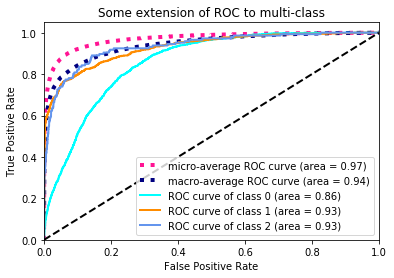

In [26]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

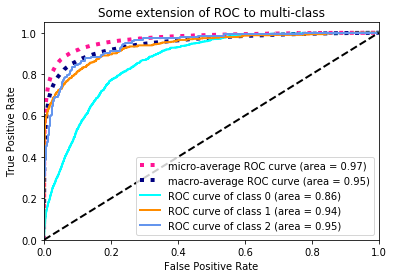

In [27]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

## Tuning Hyperparameters

In [28]:
def eval_bow(X_train_mybag, y_train, X_val_mybag, y_val, C):
    
    clf = OneVsRestClassifier(estimator=LogisticRegression(C=C))
    clf.fit(X_train_mybag, y_train)
    y_val_predicted_labels_mybag = clf.predict(X_val_mybag)
    print('Evaluation metrics for C =', C, ':')
    print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
    
for C in [0.5, 1, 10, 100]:
    eval_bow(X_train_mybag, y_train, X_val_mybag, y_val, C=C)

Evaluation metrics for C = 0.5 :
Accuracy score: 0.35546666666666665
F1 score: 0.6421754795935027
Precision: 0.5074979498962355
Evaluation metrics for C = 1 :
Accuracy score: 0.3617
F1 score: 0.6516894695054041
Precision: 0.5140449141164741
Evaluation metrics for C = 10 :
Accuracy score: 0.35313333333333335
F1 score: 0.6539201235517432
Precision: 0.5039311046363714
Evaluation metrics for C = 100 :
Accuracy score: 0.32043333333333335
F1 score: 0.6345389784259912
Precision: 0.47593130365905023


In [29]:
def eval_tfidf(X_train_tfidf, y_train, X_val_tfidf, y_val, C):
    
    clf = OneVsRestClassifier(estimator=LogisticRegression(C=C))
    clf.fit(X_train_tfidf, y_train)
    y_val_predicted_labels_tfidf = clf.predict(X_val_tfidf)
    print('Evaluation metrics for C =', C, ':')
    print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)
    
for C in [1, 2, 5, 10, 100]:
    eval_tfidf(X_train_tfidf, y_train, X_val_tfidf, y_val, C=C)

Evaluation metrics for C = 1 :
Accuracy score: 0.33393333333333336
F1 score: 0.614350867051105
Precision: 0.4850977390709925
Evaluation metrics for C = 2 :
Accuracy score: 0.3537
F1 score: 0.6368529046733523
Precision: 0.5034716662035972
Evaluation metrics for C = 5 :
Accuracy score: 0.36443333333333333
F1 score: 0.6514834364301708
Precision: 0.512713884853713
Evaluation metrics for C = 10 :
Accuracy score: 0.36306666666666665
F1 score: 0.6540489488810934
Precision: 0.510276783683163
Evaluation metrics for C = 100 :
Accuracy score: 0.32053333333333334
F1 score: 0.6275458414967682
Precision: 0.46392527411356665


Select C = 10 for training the classifier using tfidf and making predictions on the test set.

In [30]:
clf = OneVsRestClassifier(estimator=LogisticRegression(C=10))
clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [31]:
test_predictions = clf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

## Example of test samples and predicted tags

In [32]:
for i in range(20):
    print(X_test[i], test_pred_inversed[i])

warning mysql_query expects parameter 2 resource object given ('mysql', 'php')
get click coordinates input typeimage via javascript ('html', 'javascript', 'jquery')
implement cloud storage media assets zf ()
catcomplete jquerys autocomplete plugin ('javascript', 'jquery')
error building android app cordova 31 cli ('android', 'java')
parse xml file php ('parsing', 'php', 'xml')
uploading files via json post request web service provided teambox ('json',)
adding rows jtable right order ('java', 'swing')
read input file python ('file', 'python')
pdf generation html containing images text ('html',)
trying get sql query dynamic jquery ('jquery', 'php', 'sql')
fiting 2parameters weibull distribution tabulated data ('r',)
add six months php ('php',)
code constants rails 3 application ('ruby-on-rails',)
comparing list items one column datatable ('asp.net', 'c#')
python sort upper case lower case ('python',)
make pointer multidimensional array unknown size ('c++',)
rails 3 trigger ajax submit ra